# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

import sklearn.model_selection
from scipy.stats import randint as sp_randint

In [2]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

X_dev: (250, 200), y_dev: (250, 1) para desarrollo
X_eval: (250, 200), y_eval: (250, 1) para evaluación


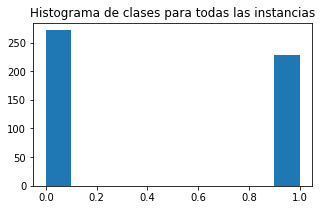

229


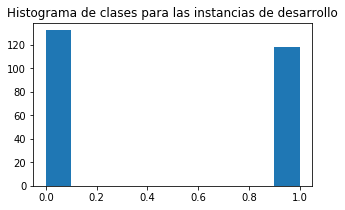

118


In [3]:
# EJERCICIO 1. 
from sklearn.model_selection import KFold

np.random.seed(1234)

########################################################
## AQUI VA SU CODIGO
#X_dev, X_eval, y_dev, y_eval = X, X, y, y  # cambiar esta línea si lo consideran necesario

X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(
    X, y, random_state=1234, test_size=0.5)

# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas
#########################################################


print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y))  # muestra un histograma para la distribución de y.
plt.title('Histograma de clases para todas las instancias')
plt.show()
print(y['output'].sum()) #229/500 = 46% de todas son true

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.title('Histograma de clases para las instancias de desarrollo')
plt.show()
print(y_dev['output'].sum()) #118/250 = 47% de las de dev son true

### Discusión

En principio, la división de las instancias para desarrollo y validación debe ser aleatoria, puesto que para este conjunto de datos las instancias no parecen estar ordenadas bajo algún criterio. Tampoco tenemos información sobre la importancia de los atributos. 

Tenemos 500 instancias disponibles para hacer esta separación. Teniendo en cuenta la competencia, debemos seleccionar un modelo y estimar su performance sobre las instancias _para la competencia_. Estas son 5000 en total, una cantidad bastante mayor al máximo que podríamos destinar para entrenamiento. Teniendo en cuenta este desbalance, consideramos que para poder obtener un estimado realista al utilizar las instancias _held out_, la cantidad de instancias destinadas para este fin debe ser igual o mayor a la cantidad utilizadas para entrenamiento. De esta manera, se intentará reflejar este desbalance entre cantidades.

No obstante, reservar pocas instancias para entrenamiento acarrea también el riesgo de desarrollar modelos poco predictivos. Por esa razón, decidimos separar las instancias en *dos mitades iguales* para entrenamiento y validación, de forma aleatoria. 

Observamos también que, sobre el total de las 500 instancias, 229 pertenecen a la clase $1$, un poco menos que la mitad (el $46 \% $ ). De manera tal de evitar un sesgo en la selección, nos aseguramos que este porcentaje de instancias se refleje también en las reservadas para entrenamiento (resulta del $ 47 \%$).



## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

[0.9, 0.9, 0.845, 0.875, 0.875]


,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.900,0.68,0.9463,0.7011
2,0.900,0.68,0.9460,0.6526
3,0.845,0.56,0.9134,0.6177
4,0.875,0.76,0.9323,0.8194
5,0.875,0.80,0.9518,0.8584


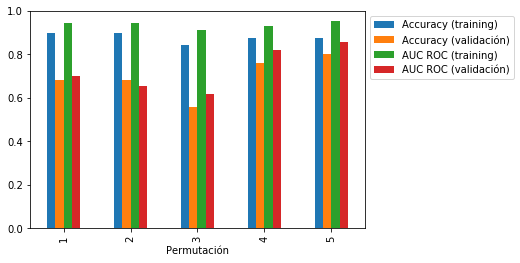

In [39]:
##CORREGIDO

from sklearn.tree import DecisionTreeClassifier

accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
## AQUI VA SU CODIGO 
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados


#kf = KFold(n_splits=5, random_state=1234, shuffle=True)

# ya que las instancias no tienen orden aparente (y ya habían sido seleccionadas aleatoriamente al reservar las 
# de desarollo), no hace falta mezclarlas en el K-fold cross validation

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_dev):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
    y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]
    
    arbol = DecisionTreeClassifier(max_depth=3)
    arbol.fit(X_train, y_train)
    
    y_pred_test = arbol.predict(X_test)
    y_pred_train = arbol.predict(X_train)
    
    y_pred_test_proba = arbol.predict_proba(X_test)
    y_pred_train_proba = arbol.predict_proba(X_train)
    
    y_pred_test_proba=y_pred_test_proba[:,1]
    y_pred_train_proba=y_pred_train_proba[:,1]
    
    ac_test=sklearn.metrics.accuracy_score(y_test, y_pred_test, normalize=True, sample_weight=None)
    ac_train=sklearn.metrics.accuracy_score(y_train, y_pred_train, normalize=True, sample_weight=None)
    accuracies_validation.append(ac_test)
    accuracies_training.append(ac_train)
    
    roc_auc_test=sklearn.metrics.roc_auc_score(y_test, y_pred_test_proba, sample_weight=None)
    roc_auc_train=sklearn.metrics.roc_auc_score(y_train, y_pred_train_proba, sample_weight=None)
    aucs_training.append(roc_auc_train)
    aucs_validation.append(roc_auc_test)
#########################################################

print(accuracies_training)

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training     # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracies_validation   # cambiar por accuracies_validation
df["AUC ROC (training)"] = aucs_training     # cambiar por aucs_training
df["AUC ROC (validación)"] = aucs_validation    # ["-"] * 5 cambiar por aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [40]:
arbol = DecisionTreeClassifier(max_depth=3)
arbol.fit(X_train, y_train)
  
y_pred_test = arbol.predict(X_test)
y_pred_train = arbol.predict(X_train)    
print(y_pred_train)
print(type(y_pred_train))


y_pred_test = arbol.predict_proba(X_test)
y_pred_train = arbol.predict_proba(X_train)
print(y_pred_train)
print(y_pred_train[:,1])
print(type(y_pred_train))
print(type(y_pred_train[:,1]))

[1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1
 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0
 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0
 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1]
<class 'numpy.ndarray'>
[[0.1818 0.8182]
 [0.05   0.95  ]
 [0.05   0.95  ]
 [0.05   0.95  ]
 [1.     0.    ]
 [0.5    0.5   ]
 [0.8125 0.1875]
 [1.     0.    ]
 [0.9091 0.0909]
 [0.5    0.5   ]
 [1.     0.    ]
 [0.1818 0.8182]
 [0.5    0.5   ]
 [0.9091 0.0909]
 [0.05   0.95  ]
 [0.05   0.95  ]
 [1.     0.    ]
 [1.     0.    ]
 [1.     0.    ]
 [0.5    0.5   ]
 [1.     0.    ]
 [0.9091 0.0909]
 [0.05   0.95  ]
 [0.5    0.5   ]
 [0.5    0.5   ]
 [1.     0.    ]
 [0.5    0.5   ]
 [0.05   0.95  ]
 [0.05   0.95  ]
 [0.8125 0.1875]
 [0.1818 0.8182]
 [0.1818 0.8182]
 [1.     0.    ]
 [0.05  

In [41]:
##CORREGIDO

resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
np.random.seed(SEED)
for criterio in ["gini", "entropy"]:
     for altura in [3, 5, None]:
        
        lista_aucs_train = []
        lista_aucs_test = []
        
        for train_index, test_index in kf.split(X_dev):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
            y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]

            arbol = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
            arbol.fit(X_train, y_train)

            y_pred_test = arbol.predict(X_test)
            y_pred_train = arbol.predict(X_train)
            
            y_pred_test_proba = arbol.predict_proba(X_test)
            y_pred_train_proba = arbol.predict_proba(X_train)
    
            y_pred_test_proba=y_pred_test_proba[:,1]
            y_pred_train_proba=y_pred_train_proba[:,1]
    

            #ac_test=sklearn.metrics.accuracy_score(y_test, y_pred_test, normalize=True, sample_weight=None)
            #ac_train=sklearn.metrics.accuracy_score(y_train, y_pred_train, normalize=True, sample_weight=None)
            #accuracies_validation.append(ac_test)
            #accuracies_training.append(ac_train)  
            
            #EN EL PDF DICE ACURACY, ACA FIGURA AUC ROC
            
            roc_auc_test=sklearn.metrics.roc_auc_score(y_test, y_pred_test_proba, sample_weight=None)
            roc_auc_train=sklearn.metrics.roc_auc_score(y_train, y_pred_train_proba, sample_weight=None)
            lista_aucs_train.append(roc_auc_train)
            lista_aucs_test.append(roc_auc_test)
                

        resultados_training.append( np.mean(lista_aucs_train) )
        resultados_validation.append( np.mean(lista_aucs_test) )
#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)


,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.9401,0.7406
1,5,Gini,0.9957,0.6643
2,Inifinito,Gini,1.0000,0.6849
3,3,Ganancia de Información,0.9453,0.7698
4,5,Ganancia de Información,0.9975,0.7357
5,Inifinito,Ganancia de Información,1.0000,0.7163


## Punto Extra

In [21]:
import numpy as np
import pandas as pd

from collections import Counter
from math import log

def construir_arbol(instancias, etiquetas, criterion, max_depth):
    # ALGORITMO RECURSIVO para construcción de un árbol de decisión binario. 
    
    if max_depth == 0 or len(instancias) <= 2:
        return Hoja(etiquetas)
    
    # Suponemos que estamos parados en la raiz del árbol y tenemos que decidir cómo construirlo. 
    ganancia, pregunta = encontrar_mejor_atributo_y_corte(instancias, etiquetas, criterion)
    
    # Criterio de corte: ¿Hay ganancia?
    if ganancia == 0:
        #  Si no hay ganancia en separar, no separamos. 
        return Hoja(etiquetas)
    else: 
        # Si hay ganancia en partir el conjunto en 2
        instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen = partir_segun(pregunta, instancias, etiquetas, criterion)
        # partir devuelve instancias y etiquetas que caen en cada rama (izquierda y derecha)

        new_max_depth = None
        if max_depth != None:
            new_max_depth = max_depth - 1
            
        # Paso recursivo (consultar con el computador más cercano)
        sub_arbol_izquierdo = construir_arbol(instancias_cumplen, etiquetas_cumplen, criterion, new_max_depth)
        sub_arbol_derecho   = construir_arbol(instancias_no_cumplen, etiquetas_no_cumplen, criterion, new_max_depth)
        # los pasos anteriores crean todo lo que necesitemos de sub-árbol izquierdo y sub-árbol derecho
        
        # sólo falta conectarlos con un nodo de decisión:
        return Nodo_De_Decision(pregunta, sub_arbol_izquierdo, sub_arbol_derecho)
    
    
# Definición de la estructura del árbol. 

class Hoja:
    #  Contiene las cuentas para cada clase (en forma de diccionario)
    #  Por ejemplo, {'Si': 2, 'No': 2}
    def __init__(self, etiquetas):
        self.cuentas = dict(Counter(etiquetas))


class Nodo_De_Decision:
    # Un Nodo de Decisión contiene preguntas y una referencia al sub-árbol izquierdo y al sub-árbol derecho
     
    def __init__(self, pregunta, sub_arbol_izquierdo, sub_arbol_derecho):
        self.pregunta = pregunta
        self.sub_arbol_izquierdo = sub_arbol_izquierdo
        self.sub_arbol_derecho = sub_arbol_derecho
        
        
# Definición de la clase "Pregunta"
class Pregunta:
    def __init__(self, atributo, valor):
        self.atributo = atributo
        self.valor = valor
    
    def cumple(self, instancia):
        # Devuelve verdadero si la instancia cumple con la pregunta
        return instancia[self.atributo] == self.valor
    
    def __repr__(self):
        try:
            float(self.valor)
            return "¿Es el valor para {} <= a {}?".format(self.atributo, self.valor)
        except:
            return "¿Es el valor para {} igual a {}?".format(self.atributo, self.valor)
    
def gini(etiquetas):
    d = dict(Counter(etiquetas))
    impureza = 1
    for key, value in d.items():
        impureza -= (value/len(etiquetas))**2
    return impureza

def ganancia_gini(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha):
    # COMPLETAR
    ganancia_previa = gini(etiquetas_rama_izquierda + etiquetas_rama_derecha)
    gini_izq = gini(etiquetas_rama_izquierda)
    
    proporcion_izq = (len(etiquetas_rama_izquierda)/len(instancias))
    proporcion_der = (len(etiquetas_rama_derecha)/len(instancias))
    
    gini_der = gini(etiquetas_rama_derecha)
    ganancia_gini = ganancia_previa - ((gini_izq*proporcion_izq + gini_der*proporcion_der)/2)
    return ganancia_gini

def entropy(etiquetas):
    d = dict(Counter(etiquetas))
    entropy = 0
    for key, value in d.items():
        proportion = value/len(etiquetas)
        entropy -= (proportion)*log(proportion, 2)
    return entropy

def ganancia_entropy(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha):
    
    ganancia_previa = entropy(etiquetas_rama_izquierda + etiquetas_rama_derecha)
    entropy_izq = gini(etiquetas_rama_izquierda)
    
    proporcion_izq = (len(etiquetas_rama_izquierda)/len(instancias))
    proporcion_der = (len(etiquetas_rama_derecha)/len(instancias))
    
    entropy_der = gini(etiquetas_rama_derecha)
    ganancia_entropia = ganancia_previa - ((entropy_izq*proporcion_izq + entropy_der*proporcion_der)/2)
    return ganancia_entropia

    
def get_ganancia(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha, criterion):
    
    if criterion == "gini":
        return ganancia_gini(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha)
    else:
        return ganancia_entropy(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha)
    

def partir_segun(pregunta, instancias, etiquetas, criterion):

    try:
        float(pregunta.valor)
        return partir_segun_attr_numerico(pregunta, instancias, etiquetas, criterion)
    except:
        return partir_segun_attr_discreto(pregunta, instancias, etiquetas, criterion)
    
def partir_segun_attr_discreto(pregunta, instancias, etiquetas, criterion):
    
    # Esta función debe separar instancias y etiquetas según si cada instancia cumple o no con la pregunta (ver método 'cumple')
    # COMPLETAR (recomendamos utilizar máscaras para este punto)
    
    instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen = list(), list(), list(), list()

    index = 0
    for x, instance in instancias.iterrows():

        if instance[pregunta.atributo] == pregunta.valor:
            instancias_cumplen.append(instance)
            etiquetas_cumplen.append(etiquetas[index])
        else:
            instancias_no_cumplen.append(instance)
            etiquetas_no_cumplen.append(etiquetas[index])
        index += 1
    return pd.DataFrame(instancias_cumplen), etiquetas_cumplen, pd.DataFrame(instancias_no_cumplen), etiquetas_no_cumplen

def partir_segun_attr_numerico(pregunta, instancias, etiquetas, criterion):
    
    instancias_copy = instancias.copy()
    instancias_copy["___tmp___"] = etiquetas
    
    cut = pregunta.valor
    cumplen = instancias_copy[instancias_copy[pregunta.atributo] < cut]
    no_cumplen = instancias_copy[instancias_copy[pregunta.atributo] >= cut]
    etiquetas_cumplen = list(cumplen["___tmp___"])
    etiquetas_no_cumplen = list(no_cumplen["___tmp___"])
    del cumplen["___tmp___"]
    del no_cumplen["___tmp___"]
    
    return cumplen, etiquetas_cumplen, no_cumplen, etiquetas_no_cumplen 

def encontrar_mejor_atributo_y_corte(instancias, etiquetas, criterion):
    
    max_ganancia = 0
    mejor_pregunta = None
    for columna in instancias.columns:
        
        try:
            for valor in set(instancias[columna]): #asegurarse que son valores numericos
                float(valor)
            
            instancias_tmp = instancias.copy()
            instancias_tmp["___tmp___"] = etiquetas
            instancias_tmp.sort_values(columna)
            etiquetas_tmp = instancias_tmp["___tmp___"]
            del instancias_tmp["___tmp___"]
            
            if len(instancias_tmp) == 1:
                pregunta = Pregunta(columna, 0) #da igual
                _, etiquetas_rama_izquierda, _, etiquetas_rama_derecha = partir_segun_attr_numerico(pregunta, instancias_tmp, etiquetas_tmp, criterion)
                ganancia = get_ganancia(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha, criterion)
                if ganancia > max_ganancia:
                    max_ganancia = ganancia
                    mejor_pregunta = pregunta
            else:
                
                instancia_anterior = None
                mejor_ganancia_hasta_ahora = 0
                for x, una_instancia in instancias_tmp.iterrows():
                    if instancia_anterior is None:
                        instancia_anterior = una_instancia
                    else:
                        cut = (instancia_anterior[columna] + una_instancia[columna])/2
                        #num_pregunta += 1
                        #print(num_pregunta)
                        pregunta = Pregunta(columna, cut)
                        _, etiquetas_rama_izquierda, _, etiquetas_rama_derecha = partir_segun_attr_numerico(pregunta, instancias_tmp, etiquetas_tmp, criterion)
                        ganancia = get_ganancia(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha, criterion)
                        if ganancia > max_ganancia:
                            max_ganancia = ganancia
                            mejor_pregunta = pregunta
                        instancia_anterior = una_instancia
        
        except:
            for valor in set(instancias[columna]):
                # Probando corte para atributo y valor
                pregunta = Pregunta(columna, valor)
                _, etiquetas_rama_izquierda, _, etiquetas_rama_derecha = partir_segun_attr_discreto(pregunta, instancias, etiquetas, criterion)

                ganancia = get_ganancia(instancias, etiquetas_rama_izquierda, etiquetas_rama_derecha, criterion)

                if ganancia > max_ganancia:
                    max_ganancia = ganancia
                    mejor_pregunta = pregunta
      
    return max_ganancia, mejor_pregunta

def predecir(arbol, x_t):
    
    if isinstance(arbol, Hoja):
        max = 0
        return_value = None
        for key,value in arbol.cuentas.items():
            if value > max:
                return_value = key
                max = value
        return return_value
    
    else:
        attr = arbol.pregunta.atributo
        val = arbol.pregunta.valor
        try:
            float(val)
            if x_t[attr] < val:
                return predecir(arbol.sub_arbol_izquierdo, x_t)    
            else:
                return predecir(arbol.sub_arbol_derecho, x_t)
        except:
            if(x_t.loc[attr]) == val:
                return predecir(arbol.sub_arbol_izquierdo, x_t)
            else:
                return predecir(arbol.sub_arbol_derecho, x_t)

        
class CustomDecisionTreeClassifier(): 
    def __init__(self, criterion = "gini", max_depth=None):
        self.arbol = None
        if criterion != "gini" and criterion != "entropy":
            raise Exception("Criterio desconocido")
        
        self.criterion = criterion
        self.max_depth = max_depth
    
    def fit(self, X_train, y_train):
        self.arbol = construir_arbol(pd.DataFrame(X_train), y_train, criterion=self.criterion, max_depth=self.max_depth)
        return self
    
    def predict(self, X_test):
        predictions = []
        for x_t in X_test:
            x_t_df = pd.DataFrame([x_t]).iloc[0]
            prediction = predecir(self.arbol, x_t_df) 
            predictions.append(prediction)
        return predictions
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        
        accuracy = sum(y_i == y_j for (y_i, y_j) in zip(y_pred, y_test)) / len(y_test)
        return accuracy
        
def imprimir_arbol(arbol, spacing=""):
    
    if isinstance(arbol, MiClasificadorArbol):
        imprimir_arbol(arbol.arbol)
        return
    
    if isinstance(arbol, Hoja):
        print (spacing + "Hoja:", arbol.cuentas)
        return

    print (spacing + str(arbol.pregunta))

    print (spacing + '--> True:')
    imprimir_arbol(arbol.sub_arbol_izquierdo, spacing + "  ")

    print (spacing + '--> False:')
    imprimir_arbol(arbol.sub_arbol_derecho, spacing + "  ")


In [14]:

accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
## AQUI VA SU CODIGO 
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados


kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_dev):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
    y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]
    
    arbol = CustomDecisionTreeClassifier(max_depth=3)
    arbol.fit(X_train, y_train)
    
    y_pred_test = arbol.predict(X_test)
    y_pred_train = arbol.predict(X_train)
    
    ac_test=sklearn.metrics.accuracy_score(y_test, y_pred_test, normalize=True, sample_weight=None)
    ac_train=sklearn.metrics.accuracy_score(y_train, y_pred_train, normalize=True, sample_weight=None)
    accuracies_validation.append(ac_test)
    accuracies_training.append(ac_train)
    
    roc_auc_test=sklearn.metrics.roc_auc_score(y_test, y_pred_test, sample_weight=None)
    roc_auc_train=sklearn.metrics.roc_auc_score(y_train, y_pred_train, sample_weight=None)
    aucs_training.append(roc_auc_train)
    aucs_validation.append(roc_auc_test)

#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training     # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracies_validation   # cambiar por accuracies_validation
df["AUC ROC (training)"] = aucs_training     # cambiar por aucs_training
df["AUC ROC (validación)"] = aucs_validation    # ["-"] * 5 cambiar por aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

NameError: name 'CustomDecisionTreeClassifier' is not defined

In [24]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
np.random.seed(SEED)
for criterio in ["gini", "entropy"]:
     for altura in [3, 5, None]:
        
        lista_aucs_train = []
        lista_aucs_test = []
        
        for train_index, test_index in kf.split(X_dev):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
            y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]

            arbol = CustomDecisionTreeClassifier(max_depth=altura, criterion=criterio)
            arbol.fit(X_train, y_train)

            y_pred_test = arbol.predict(X_test)
            y_pred_train = arbol.predict(X_train)

            #ac_test=sklearn.metrics.accuracy_score(y_test, y_pred_test, normalize=True, sample_weight=None)
            #ac_train=sklearn.metrics.accuracy_score(y_train, y_pred_train, normalize=True, sample_weight=None)
            #accuracies_validation.append(ac_test)
            #accuracies_training.append(ac_train)  
            
            #EN EL PDF DICE ACURACY, ACA FIGURA AUC ROC
            
            roc_auc_test=sklearn.metrics.roc_auc_score(y_test, y_pred_test, sample_weight=None)
            roc_auc_train=sklearn.metrics.roc_auc_score(y_train, y_pred_train, sample_weight=None)
            lista_aucs_train.append(roc_auc_train)
            lista_aucs_test.append(roc_auc_test)
                

        resultados_training.append( np.mean(lista_aucs_train) )
        resultados_validation.append( np.mean(lista_aucs_test) )
#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8818,0.6801
1,5,Gini,0.9789,0.6487
2,Inifinito,Gini,0.9968,0.6368
3,3,Ganancia de Información,0.8818,0.6801
4,5,Ganancia de Información,0.9789,0.6487
5,Inifinito,Ganancia de Información,0.9968,0.6368


## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

########################################################
## AQUI VA SU CODIGO 
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba

X_eval_np = np.array(X_eval)
y_eval_np = np.array(y_eval).ravel()
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

X_train=X_dev_np
X_test=X_eval_np
y_train=y_dev_np
y_test=y_eval_np

########################################################

Definimos un wrapper a ```GridSearchCV``` para conveniencia

In [44]:
from sklearn.metrics import classification_report

def GridSearch(model, tuned_parameters):
    scores = ['roc_auc']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(model, tuned_parameters, cv=5,
                           scoring='%s' % score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        #print("Detailed classification report:")
        #print()
        #print("The model is trained on the full development set.")
        #print("The scores are computed on the full evaluation set.")
        #print()
        #y_true, y_pred = y_test, clf.predict(X_test)
        #print(classification_report(y_true, y_pred))
        #print()
    

### Ejecutamos efectivamente la grid search
### KNN

In [45]:
tuned_parameters = [{'n_neighbors':range(1, len(X_test)//2, 10), 'weights':["uniform", "distance"], 'p':range(1, 3)}]
%time GridSearch(KNeighborsClassifier(), tuned_parameters)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'n_neighbors': 51, 'p': 1, 'weights': 'distance'}

Grid scores on development set:

0.707 (+/-0.153) for {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.707 (+/-0.153) for {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.708 (+/-0.070) for {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.708 (+/-0.070) for {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.866 (+/-0.081) for {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
0.871 (+/-0.086) for {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
0.867 (+/-0.098) for {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
0.872 (+/-0.098) for {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
0.874 (+/-0.106) for {'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}
0.876 (+/-0.108) for {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
0.878 (+/-0.113) for {'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}
0.880 (+/-0.110) for {'n_neighbors': 21, 'p': 2

/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
y_test


array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0])

### Árboles de decisión

In [46]:
tuned_parameters = [{'max_depth':range(1,6) , 'criterion': ["gini", "entropy"]}]
%time GridSearch(DecisionTreeClassifier(), tuned_parameters)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 2}

Grid scores on development set:

0.702 (+/-0.087) for {'criterion': 'gini', 'max_depth': 1}
0.753 (+/-0.145) for {'criterion': 'gini', 'max_depth': 2}
0.752 (+/-0.170) for {'criterion': 'gini', 'max_depth': 3}
0.711 (+/-0.149) for {'criterion': 'gini', 'max_depth': 4}
0.664 (+/-0.132) for {'criterion': 'gini', 'max_depth': 5}
0.692 (+/-0.120) for {'criterion': 'entropy', 'max_depth': 1}
0.765 (+/-0.096) for {'criterion': 'entropy', 'max_depth': 2}
0.745 (+/-0.089) for {'criterion': 'entropy', 'max_depth': 3}
0.741 (+/-0.081) for {'criterion': 'entropy', 'max_depth': 4}
0.720 (+/-0.100) for {'criterion': 'entropy', 'max_depth': 5}

CPU times: user 45.9 ms, sys: 8.07 ms, total: 54 ms
Wall time: 314 ms


/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### LDA

In [47]:
#tuned_parameters = [{'solver':['svd','lsqr']}]
#tuned_parameters = [{'solver':['lsqr'],'shrinkage':[None,'auto']}]
#param_grid = [{'solver':['svd']},{'solver':['lsqr'],'shrinkage':[None,'auto']}]

tuned_parameters= [{'solver':['svd']},{'solver':['lsqr'],'shrinkage':[None,'auto']}]

%timeit GridSearch(LinearDiscriminantAnalysis(), tuned_parameters)

# Tuning hyper-parameters for roc_auc



/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'shrinkage': 'auto', 'solver': 'lsqr'}

Grid scores on development set:

0.538 (+/-0.070) for {'solver': 'svd'}
0.547 (+/-0.187) for {'shrinkage': None, 'solver': 'lsqr'}
0.875 (+/-0.107) for {'shrinkage': 'auto', 'solver': 'lsqr'}

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'shrinkage': 'auto', 'solver': 'lsqr'}

Grid scores on development set:

0.538 (+/-0.070) for {'solver': 'svd'}
0.547 (+/-0.187) for {'shrinkage': None, 'solver': 'lsqr'}
0.875 (+/-0.107) for {'shrinkage': 'auto', 'solver': 'lsqr'}

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'shrinkage': 'auto', 'solver': 'lsqr'}

Grid scores on development set:

0.538 (+/-0.070) for {'solver': 'svd'}
0.547 (+/-0.187) for {'shrinkage': None, 'solver': 'lsqr'}
0.875 (+/-0.107) for {'shrinkage': 'auto', 'solver': 'lsqr'}

# Tuning hyper-parameters for roc_auc



/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'shrinkage': 'auto', 'solver': 'lsqr'}

Grid scores on development set:

0.538 (+/-0.070) for {'solver': 'svd'}
0.547 (+/-0.187) for {'shrinkage': None, 'solver': 'lsqr'}
0.875 (+/-0.107) for {'shrinkage': 'auto', 'solver': 'lsqr'}

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'shrinkage': 'auto', 'solver': 'lsqr'}

Grid scores on development set:

0.538 (+/-0.070) for {'solver': 'svd'}
0.547 (+/-0.187) for {'shrinkage': None, 'solver': 'lsqr'}
0.875 (+/-0.107) for {'shrinkage': 'auto', 'solver': 'lsqr'}

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'shrinkage': 'auto', 'solver': 'lsqr'}

Grid scores on development set:

0.538 (+/-0.070) for {'solver': 'svd'}
0.547 (+/-0.187) for {'shrinkage': None, 'solver': 'lsqr'}
0.875 (+/-0.107) for {'shrinkage': 'auto', 'solver': 'lsqr'}

# Tuning hyper-parameters for roc_auc

Best parameters set found on development

/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Naive Bayes

In [48]:
tuned_parameters = [{'priors':[None,[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4],[0.7,0.3],[0.8,0.2],[0.9,0.1]]}]
% timeit GridSearch(GaussianNB(), tuned_parameters)

UsageError: Line magic function `%` not found.


### Linear SVM

In [49]:
a=np.logspace(-4, 4, num=49, endpoint=True, base=10.0, dtype=None)
tuned_parameters = [{'C':a}]
%time GridSearch(LinearSVC(), tuned_parameters)

a=np.logspace(-3, -2, num=49, endpoint=True, base=10.0, dtype=None)
tuned_parameters = [{'C':a}]
%time GridSearch(LinearSVC(), tuned_parameters)

# Tuning hyper-parameters for roc_auc



/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 0.0014677992676220691}

Grid scores on development set:

0.869 (+/-0.126) for {'C': 0.0001}
0.871 (+/-0.126) for {'C': 0.0001467799267622069}
0.874 (+/-0.121) for {'C': 0.00021544346900318845}
0.878 (+/-0.120) for {'C': 0.00031622776601683794}
0.879 (+/-0.115) for {'C': 0.00046415888336127773}
0.883 (+/-0.111) for {'C': 0.0006812920690579609}
0.885 (+/-0.109) for {'C': 0.001}
0.886 (+/-0.102) for {'C': 0.0014677992676220691}
0.883 (+/-0.100) for {'C': 0.002154434690031882}
0.884 (+/-0.098) for {'C': 0.0031622776601683794}
0.883 (+/-0.103) for {'C': 0.004641588833612777}
0.876 (+/-0.101) for {'C': 0.006812920690579608}
0.875 (+/-0.099) for {'C': 0.01}
0.868 (+/-0.102) for {'C': 0.01467799267622069}
0.864 (+/-0.108) for {'C': 0.021544346900318822}
0.861 (+/-0.106) for {'C': 0.03162277660168379}
0.854 (+/-0.109) for {'C': 0.046415888336127774}
0.853 (+/-0.111) for {'C': 0.06812920690579609}
0.851 (+/-0.109) for {'C': 0.1}
0.849 (+/-0.10

/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Conclusiones Grid Search

Presentamos a continuación los diferentes modelos utilizados, con los hiper-parámetros barridos, el mejor set, y la performance de dicho set. En el modelo LinearSVC se realizaron dos barridos. En el modelo GaussianNB todos los barridos obtuvieron exactamente la misma performance. En el modelo LDA presentamos la performance de todos los sets de hiper-parámetros.

**KNN**: 

Tuned parameters: {'n_neighbors': range(1, 121, 10), 'weights': ['uniform', 'distance'], 'p': range(1, 3)}<br>
**Best** parameters set: {'n_neighbors': 51, 'p': 1, 'weights': 'distance'}  <br> 
Best score: 0.885 (+/-0.121)


**Árboles**:

Tuned parameters: {'max_depth': range(1,6), 'criterion': ['gini', 'entropy']}<br>
**Best** parameters set: {'criterion': 'entropy', 'max_depth': 2}<br>
Best score: 0.765 (+/-0.096)

**LDA**:

Tuned parameters: {'solver': ['svd']}, {'solver': ['lsqr'], 'shrinkage': [None,'auto']}<br>
**Best** parameters set: {'shrinkage': 'auto', 'solver': 'lsqr'}<br>
Best score: 0.875 (+/-0.107)<br>
Other scores:<br>
0.538 (+/-0.070) for {'solver': 'svd'}<br>
0.480 (+/-0.206) for {'shrinkage': None, 'solver': 'lsqr'}


**GaussianNB**:

Tuned parameters: {'priors': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]]}<br>
**Best** parameters set: {'priors': None}<br>
Best score: 0.877 (+/-0.083)

**LinearSVC**:

Tuned parameters: {'C': np.logspace(-4, 4, num=49, base=10.0)}<br>
&<br>
Tuned parameters: {'C': np.logspace(-3, -2, num=49, base=10.0)}<br>
**Best** parameters set: {'C': 0.001539926526059492}<br>
Best score: 0.887 (+/-0.100)

**Conclusiones**:

Exceptuando el método de árboles, en todos los métodos obtenemos una performance similar de aproximadamente $0.88 \pm 0.1$

En el caso del método LDA vemos que la performance mejora considerablemente en el mejor set contra los otros dos, algo que no ocurre con el resto, en los que los resultados se mantienen similares entre sí. En la documentación del algoritmo encontramos que la herramienta "shrinkage" mejora la estimación de la matriz de covarianza en el caso en que el número de instancias de entrenamiento es chico comparado con el número de atributos. En nuestro caso tenemos 250 instancias de entrenamiento y 200 atributos en cada una de ellas, por lo que resulta coherente este resultado.

El mejor resultado obtenido lo encontramos utilizando LinearSVC, aunque por un margen pequeño. Es impotante destacar que todos los modelos tienen performances similares y que ninguno de ellos supera el 88% en roc auc, con la excepción de los árboles de decisión, que tienen un rendimiento notoriamente inferior. Estos resultados sugieren que ningún modelo, en principio, superaria ese ~12% error y por tanto este porcentaje correspondería a ruido en la muestra. También parecen indicar que la muestra es (casi) linealmente separable, y por eso todos los modelos son parecidos entre sí (pues todos los modelos que se usan son lineales). El caso del arbol de decisión indicaría que los datos no son linealmente separables _en una dimensión_, pero viendo los resultados de otros clasificadores sí lo serían considerando las 200 dimensiones de cada instancia.


### Punto Extra

In [51]:
#Extra

from sklearn.model_selection import RandomizedSearchCV

def RandomSearch(model, tuned_parameters, n_iter):
    scores = ['roc_auc']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = RandomizedSearchCV(model,param_distributions=tuned_parameters, n_iter=n_iter,cv=5,
                           scoring='%s' % score, random_state = 1234, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()


### KNN

In [52]:
tuned_parameters = {'n_neighbors':range(1, len(X_test)//2, 10), 'weights':["uniform", "distance"], 'p':range(1, 3)}
%time RandomSearch(KNeighborsClassifier(), tuned_parameters,n_iter=50)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'weights': 'distance', 'p': 1, 'n_neighbors': 51}

Grid scores on development set:

0.865 (+/-0.126) for {'weights': 'uniform', 'p': 1, 'n_neighbors': 101}
0.877 (+/-0.118) for {'weights': 'distance', 'p': 2, 'n_neighbors': 61}
0.867 (+/-0.127) for {'weights': 'distance', 'p': 2, 'n_neighbors': 91}
0.866 (+/-0.127) for {'weights': 'uniform', 'p': 1, 'n_neighbors': 111}
0.867 (+/-0.098) for {'weights': 'uniform', 'p': 2, 'n_neighbors': 11}
0.862 (+/-0.132) for {'weights': 'uniform', 'p': 2, 'n_neighbors': 111}
0.878 (+/-0.109) for {'weights': 'distance', 'p': 1, 'n_neighbors': 31}
0.874 (+/-0.106) for {'weights': 'uniform', 'p': 1, 'n_neighbors': 21}
0.868 (+/-0.137) for {'weights': 'distance', 'p': 1, 'n_neighbors': 121}
0.874 (+/-0.123) for {'weights': 'distance', 'p': 2, 'n_neighbors': 71}
0.866 (+/-0.081) for {'weights': 'uniform', 'p': 1, 'n_neighbors': 11}
0.885 (+/-0.121) for {'weights': 'dista

/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Árboles de decisión

In [53]:
tuned_parameters = {'max_depth':range(1,15) , 'criterion': ["gini", "entropy"]}
n_iter=20
%time RandomSearch(DecisionTreeClassifier(), tuned_parameters,n_iter)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'max_depth': 3, 'criterion': 'gini'}

Grid scores on development set:

0.683 (+/-0.110) for {'max_depth': 9, 'criterion': 'gini'}
0.753 (+/-0.145) for {'max_depth': 2, 'criterion': 'gini'}
0.690 (+/-0.122) for {'max_depth': 11, 'criterion': 'entropy'}
0.669 (+/-0.135) for {'max_depth': 5, 'criterion': 'gini'}
0.693 (+/-0.173) for {'max_depth': 4, 'criterion': 'gini'}
0.666 (+/-0.175) for {'max_depth': 8, 'criterion': 'gini'}
0.719 (+/-0.134) for {'max_depth': 5, 'criterion': 'entropy'}
0.686 (+/-0.099) for {'max_depth': 11, 'criterion': 'gini'}
0.692 (+/-0.120) for {'max_depth': 1, 'criterion': 'entropy'}
0.652 (+/-0.128) for {'max_depth': 14, 'criterion': 'gini'}
0.755 (+/-0.202) for {'max_depth': 3, 'criterion': 'gini'}
0.679 (+/-0.096) for {'max_depth': 12, 'criterion': 'entropy'}
0.683 (+/-0.124) for {'max_depth': 13, 'criterion': 'entropy'}
0.702 (+/-0.087) for {'max_depth': 1, 'criterion': 'gin

/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Linear SVM

In [54]:
a=np.logspace(-3, -2, num=100000, endpoint=True, base=10.0, dtype=None)
tuned_parameters = {'C':a}
n_iter=50
%time RandomSearch(LinearSVC(), tuned_parameters,n_iter)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'C': 0.0015025598101093456}

Grid scores on development set:

0.877 (+/-0.100) for {'C': 0.00850666436052429}
0.885 (+/-0.101) for {'C': 0.0038078147056072194}
0.883 (+/-0.101) for {'C': 0.002192115377602205}
0.884 (+/-0.103) for {'C': 0.004038369582315153}
0.876 (+/-0.102) for {'C': 0.007845288992683828}
0.876 (+/-0.101) for {'C': 0.006696505941218151}
0.883 (+/-0.101) for {'C': 0.002108595328061282}
0.885 (+/-0.100) for {'C': 0.003629573526144963}
0.883 (+/-0.096) for {'C': 0.0025846046655082725}
0.885 (+/-0.108) for {'C': 0.0012430567176970216}
0.886 (+/-0.101) for {'C': 0.00172608576369937}
0.884 (+/-0.109) for {'C': 0.0012084281186108957}
0.875 (+/-0.100) for {'C': 0.009542008440816466}
0.883 (+/-0.100) for {'C': 0.0021852614025497023}
0.883 (+/-0.097) for {'C': 0.002551784930795491}
0.884 (+/-0.109) for {'C': 0.001203928806587987}
0.880 (+/-0.101) for {'C': 0.005432345079311948}
0.878 (+/-0.102

/home/martin/Downloads/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Conclusiones Extra

Presentamos los tres modelos en los que realizamos RandomSearch, con el mejor set de hiper-parámetros, la performance de dicho set, y el tiempo de ejecución (comparado con el de GridSearch).
Recordemos que la idea de esta técnica es intentar encontrar un mejor set de hiperparámetros que pudieran no haber sido detectados debido a la discretización regular del espacio de búsqueda, pero sin empeorar los tiempos de cómputo, por lo que es esperable que sean similares a los del GridSearch.

**KNN:** 
Best score: 0.885 (+/-0.121) for {'weights': 'distance', 'p': 1, 'n_neighbors': 51}
RandomSearch wall time: 7.01 s
GRIDSearch wall time: 7.56 s

**Arboles:**
Best score: 0.765 (+/-0.096) for {'max_depth': 2, 'criterion': 'entropy'}
Wall time: 1.89 s
GRID: Wall time: 1.6 s

**Linear SVC:**
Best score: 0.887 (+/-0.100) for {'C': 0.0015262013596464125}
Wall time: 1.86 s
GRID: Wall time: 1.82 s

Comencemos destacando que los tiempos de ejecución entre ambas técnicas son similares y por tanto coincidentes con lo que esperábamos. En cuanto a los resultados, tanto en kNN como en Arboles de decision se encontraron los mismos conjuntos de hiperparámetros. Esto es así porque el espacio de búsqueda de hiperparámetros para ambos modelos es _discreto_ y por tanto RandomSearch no presenta mejoras posibles, dado que la técnica suele encontrar mejores parámetros en espacios de búsqueda densos (de hecho, como las posibilidades que se prueban se toman al azar, RandomSearch podría encontrar peores combinaciones de hiperparámetros que GridSearch en espacios discretos). En cuanto a LinearSVC, un mejor valor para C fue encontrado, lo cual es coherente tomando en cuenta que es un valor real y que por tanto la discretización del GridSearch es más proclive a saltear puntos o _zonas_ con mejores resultados.

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




## Punto 1

[1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1.]


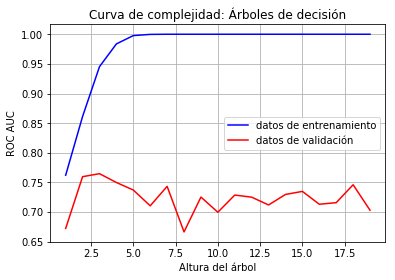

In [60]:
##CORREGIDO

# Punto 1

roc_auc_tree_train = []
roc_auc_tree_test = []

tree_lengths = np.arange(1, 20)

kf = KFold(n_splits=5, shuffle=False, random_state=1234)

for length in tree_lengths:

    lista_aucs_train = []
    lista_aucs_test = []
    
    for train_index, test_index in kf.split(X_dev):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
        y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]

        arbol = DecisionTreeClassifier(max_depth=length, criterion='entropy')
        arbol.fit(X_train, y_train)

        y_pred_test = arbol.predict_proba(X_test)
        y_pred_train = arbol.predict_proba(X_train)

        y_pred_test = y_pred_test[:,1]
        y_pred_train = y_pred_train[:,1]
        
        #print(y_pred_train)
        
        roc_auc_test=sklearn.metrics.roc_auc_score(y_test, y_pred_test, sample_weight=None)
        roc_auc_train=sklearn.metrics.roc_auc_score(y_train, y_pred_train, sample_weight=None)
        lista_aucs_train.append(roc_auc_train)
        lista_aucs_test.append(roc_auc_test)


    roc_auc_tree_train.append( np.mean(lista_aucs_train) )
    roc_auc_tree_test.append( np.mean(lista_aucs_test) )
    
print(y_pred_test)
    
plt.figure()
plt.plot(tree_lengths, roc_auc_tree_train, color = 'blue', label = 'datos de entrenamiento')
plt.plot(tree_lengths, roc_auc_tree_test, color = 'red', label = 'datos de validación')
plt.xlabel('Altura del árbol')
plt.ylabel('ROC AUC')
plt.title('Curva de complejidad: Árboles de decisión')
plt.grid(True)
plt.legend()    

### Discusión

En el caso de los árboles de decisión, el hiperparámetro que indica la complejidad es su altura; al permitir nodos más profundos, el modelo separa las instancias en un mayor número de regiones, de esa manera complejizándose. 
Al graficar la ROC AUC en función de esta complejidad para los datos de entrenamiento, vemos que la métrica aumenta hasta alcanzar un valor perfecto (cerca de la altura 5). Teniendo en cuenta que la misma métrica es bastante más baja sobre los datos de validación para esas alturas, podemos concluir que el modelo empieza a _overfittear_. Esto implica que se tiene un sesgo bajo para alturas grandes, pero también una alta varianza, ya que diferentes conjuntos de entrenamiento resultarán en modelos que se (sobre)ajustarán de manera diferente a sus datos. 

En cambio, para una altura baja, si existieran _predictores fuertes_ que separen bien a los datos se tendría una varianza baja, puesto que los diferentes árboles resultarían similares al utilizar estos predictores cerca de la raiz.   


[0.8231 0.5159 0.7298 0.235  0.1055 0.5039 0.2913 0.744  0.4257 0.3298
 0.1476 0.0573 0.4734 0.5154 0.5358 0.567  0.894  0.7111 0.3158 0.0568
 0.7618 0.5122 0.1549 0.7717 0.4299 0.8062 0.3729 0.339  0.83   0.8954
 0.4167 0.4606 0.5492 0.7513 0.0777 0.5017 0.0619 0.7394 0.2906 0.2879
 0.4412 0.2439 0.5134 0.4136 0.5592 0.3499 0.4025 0.155  0.6722 0.5687]


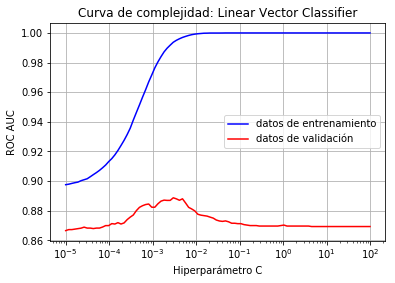

In [61]:
#¿SVC PUEDE DEVOLVER PROBAS? SI NO PUEDE, ¿COMO SE HACE EL AUC ROC?
# parece estar corregido 

from sklearn.calibration import CalibratedClassifierCV

roc_auc_svm_train = []
roc_auc_svm_test = []

svm_c = np.logspace(-5, 2, 100)

for c in svm_c:
    
    lista_aucs_train = []
    lista_aucs_test = []
    
    for train_index, test_index in kf.split(X_dev):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
        y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]

        svm = LinearSVC(C=c)
        clf = CalibratedClassifierCV(svm) 
        clf.fit(X_train, y_train)

        y_pred_test = clf.predict_proba(X_test)
        y_pred_train = clf.predict_proba(X_train)
        
        y_pred_test = y_pred_test[:,1]
        y_pred_train = y_pred_train[:,1]

        roc_auc_test=sklearn.metrics.roc_auc_score(y_test, y_pred_test, sample_weight=None)
        roc_auc_train=sklearn.metrics.roc_auc_score(y_train, y_pred_train, sample_weight=None)
        lista_aucs_train.append(roc_auc_train)
        lista_aucs_test.append(roc_auc_test)


    roc_auc_svm_train.append( np.mean(lista_aucs_train) )
    roc_auc_svm_test.append( np.mean(lista_aucs_test) )
    
print(y_pred_test)
plt.figure()
plt.semilogx(svm_c, np.array(roc_auc_svm_train), color = 'blue', label = 'datos de entrenamiento')
plt.semilogx(svm_c, np.array(roc_auc_svm_test), color = 'red', label = 'datos de validación')
plt.xlabel('Hiperparámetro C')
plt.ylabel('ROC AUC')
plt.title('Curva de complejidad: Linear Vector Classifier')
plt.grid(True)
plt.legend()

### Discusión

En el caso del SVM lineal, el hiperparámetro que cuantifica la complejidad del modelo es el $C$. Éste indica el "presupuesto" que se tiene para que instancias puedan caer dentro de un margen del hiperplano separador. Si se aumenta su valor, se permite que más instancias se ubiquen dentro de este margen. Esto hace al modelo más complejo, ya que habrán más opciones de separación. 

Estudiando la ROC AUC sobre datos de entrenamiento y validación en función de este hiperparámetro $C$, vemos un comportamiento similar al observado para los árboles de decisión. Se tiene un valor $\left( C \sim 10^{-2} \right)$ a partir del cual esta métrica es perfecta para los datos de entrenamiento pero bastante inferior para los de validación.
Nuevamente, para complejidad mayor (en este caso, un $C$ más grande) se obtienen modelos con menor sesgo pero mayor varianza. 


## Punto 2

In [62]:
# Punto 2

from sklearn.model_selection import learning_curve

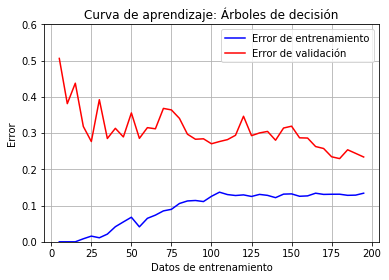

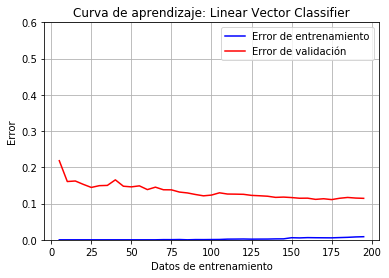

In [63]:


train_sizes, train_scores_tree, valid_scores_tree = learning_curve(
    DecisionTreeClassifier(max_depth=2, criterion='entropy'), X_dev_np, y_dev_np, train_sizes=range(5, 199, 5), cv=5, 
    scoring = 'roc_auc', n_jobs=-1)

#train_sizes, train_scores_tree, valid_scores_tree = learning_curve(
#    DecisionTreeClassifier(max_depth=2, criterion='entropy'), X, y, train_sizes=range(10, 399, 10), cv=5, 
#    scoring = 'roc_auc')


plt.figure()
plt.plot(train_sizes, 1-np.mean(train_scores_tree, axis = 1), color = 'blue', label = 'Error de entrenamiento')
plt.plot(train_sizes, 1-np.mean(valid_scores_tree, axis = 1), color = 'red', label = 'Error de validación')
plt.ylim(0, 0.6)
plt.xlabel('Datos de entrenamiento')
plt.ylabel('Error')
plt.title('Curva de aprendizaje: Árboles de decisión')
plt.grid(True)
plt.legend()

train_sizes, train_scores_svm, valid_scores_svm = learning_curve(
    LinearSVC(C=0.0015), X_dev_np, y_dev_np, train_sizes=range(5, 199, 5), cv=5, 
    scoring = 'roc_auc')

#train_sizes, train_scores_svm, valid_scores_svm = learning_curve(
#    LinearSVC(C=0.0015), X, y,train_sizes=range(10, 399, 10), cv=5, 
#    scoring = 'roc_auc')


plt.figure()
plt.plot(train_sizes, 1-np.mean(train_scores_svm, axis = 1), color = 'blue', label = 'Error de entrenamiento')
plt.plot(train_sizes, 1-np.mean(valid_scores_svm, axis = 1), color = 'red', label = 'Error de validación')
plt.ylim(0,0.6)
plt.xlabel('Datos de entrenamiento')
plt.ylabel('Error')
plt.title('Curva de aprendizaje: Linear Vector Classifier')
plt.grid(True)
plt.legend()

### Discusión
En el caso del árbol de decisión vemos que la varianza (en el gŕafico vista como la distancia entre las curvas de error de validación y entrenamiento) disminuye a medida que aumenta la cantidad de datos de entrenamiento. Por otro lado, vemos también que aumenta el sesgo, siendo éste el error sobre los datos de entrenamiento. Este aumento sólo es pronunciado _hasta los 100_ datos de entrenamiento, y luego parece mantenerse aproximadamente consante; mientras que el error de validación continúa disminuyendo en el mismo rango. Estos dos factores nos permiten pensar que al aumentar la cantidad de datos continuarán acercándose ambas curvas, ya que el error de validación baja y el de entrenamiento se mantiene. 
Entonces, podemos concluir que es conveniente aumentar la cantidad de datos para el entrenamiento; puesto que el sesgo se mantendrá y la varianza disminuirá. 

En cambio, para la SVM vemos otro comportamiento. El sesgo es relativamente bajo (en comparación con el árbol de decisión) y no parece aumentar notablemente. El error de validación disminuye ligeramente a medida que se incrementan los datos de entrenamiento; no obstante, su disminución se reduce al aumentar los datos. De esa forma, vemos que la varianza se achica gradualmente, pero parece estabilizarse al tomar el total de los datos. 
Por lo tanto, en este caso no consideramos que sea útil aumentar la cantidad de datos, pues ya parece llegarse al límite del algoritmo y no habrá mayor reducción de varianza.  


## Punto 3

In [65]:
# Punto 3

from sklearn.ensemble import RandomForestClassifier

#forest = RandomForestClassifier(n_estimators = 200, max_features='auto')
# max_features impone cuántos atributos (del total) se consideran al partir desde un nodo. El 'auto' es sqrt(n_features)




[0.08  0.17  0.795 0.15  0.185 0.125 0.805 0.12  0.895 0.21  0.12  0.12
 0.14  0.2   0.175 0.19  0.865 0.84  0.86  0.115 0.1   0.13  0.715 0.075
 0.235 0.785 0.12  0.755 0.865 0.07  0.19  0.8   0.78  0.18  0.15  0.85
 0.82  0.19  0.175 0.205 0.06  0.825 0.87  0.085 0.235 0.11  0.18  0.14
 0.17  0.11  0.11  0.785 0.805 0.12  0.22  0.85  0.125 0.08  0.82  0.125
 0.145 0.19  0.21  0.9   0.795 0.86  0.125 0.88  0.16  0.81  0.155 0.77
 0.18  0.775 0.105 0.83  0.09  0.085 0.865 0.08  0.115 0.11  0.84  0.09
 0.18  0.895 0.785 0.165 0.18  0.225 0.855 0.855 0.09  0.14  0.825 0.165
 0.8   0.795 0.11  0.76  0.835 0.145 0.815 0.135 0.83  0.91  0.9   0.71
 0.18  0.845 0.84  0.875 0.155 0.12  0.125 0.875 0.915 0.905 0.115 0.85
 0.175 0.855 0.11  0.13  0.11  0.11  0.9   0.245 0.825 0.815 0.135 0.085
 0.145 0.1   0.125 0.175 0.79  0.865 0.75  0.86  0.78  0.845 0.775 0.835
 0.885 0.91  0.13  0.165 0.685 0.85  0.89  0.805 0.865 0.175 0.08  0.155
 0.09  0.85  0.835 0.88  0.12  0.165 0.235 0.805 0.21  0.7

[0.905 0.855 0.93  0.83  0.13  0.13  0.785 0.055 0.15  0.81  0.095 0.81
 0.925 0.09  0.875 0.805 0.12  0.065 0.065 0.885 0.035 0.18  0.27  0.82
 0.82  0.16  0.145 0.91  0.945 0.075 0.875 0.18  0.065 0.82  0.16  0.115
 0.905 0.215 0.82  0.89  0.85  0.245 0.035 0.935 0.935 0.1   0.915 0.765
 0.885 0.065 0.055 0.21  0.71  0.145 0.105 0.19  0.775 0.06  0.94  0.28
 0.09  0.125 0.11  0.25  0.18  0.205 0.83  0.92  0.87  0.07  0.09  0.07
 0.7   0.06  0.135 0.715 0.105 0.785 0.905 0.055 0.155 0.785 0.79  0.245
 0.11  0.9   0.825 0.17  0.23  0.21  0.055 0.825 0.895 0.09  0.2   0.125
 0.185 0.09  0.225 0.095 0.895 0.155 0.755 0.05  0.87  0.945 0.945 0.74
 0.175 0.92  0.91  0.89  0.175 0.07  0.105 0.895 0.965 0.87  0.155 0.87
 0.1   0.945 0.19  0.075 0.085 0.065 0.955 0.18  0.815 0.815 0.09  0.105
 0.05  0.105 0.09  0.125 0.82  0.875 0.81  0.915 0.74  0.815 0.805 0.85
 0.83  0.915 0.095 0.215 0.63  0.91  0.93  0.72  0.92  0.13  0.055 0.21
 0.145 0.945 0.875 0.895 0.14  0.065 0.225 0.855 0.265 0.78

[0.92  0.925 0.9   0.875 0.175 0.09  0.755 0.055 0.11  0.76  0.05  0.835
 0.96  0.09  0.885 0.855 0.09  0.055 0.065 0.87  0.025 0.135 0.275 0.775
 0.815 0.115 0.125 0.925 0.935 0.135 0.9   0.195 0.05  0.805 0.16  0.09
 0.955 0.22  0.865 0.92  0.87  0.27  0.04  0.91  0.965 0.065 0.915 0.795
 0.89  0.06  0.06  0.15  0.735 0.195 0.105 0.195 0.765 0.055 0.95  0.285
 0.09  0.105 0.095 0.23  0.2   0.16  0.925 0.9   0.92  0.075 0.04  0.065
 0.635 0.045 0.165 0.74  0.095 0.8   0.85  0.06  0.185 0.805 0.78  0.2
 0.155 0.905 0.865 0.125 0.185 0.175 0.025 0.82  0.88  0.055 0.195 0.07
 0.18  0.08  0.275 0.045 0.11  0.835 0.795 0.055 0.245 0.845 0.07  0.035
 0.88  0.14  0.08  0.205 0.18  0.945 0.835 0.865 0.055 0.915 0.22  0.81
 0.145 0.82  0.12  0.83  0.085 0.895 0.1   0.13  0.915 0.045 0.105 0.045
 0.865 0.05  0.155 0.935 0.77  0.14  0.08  0.21  0.915 0.875 0.095 0.07
 0.905 0.085 0.88  0.8   0.11  0.895 0.925 0.175 0.85  0.04  0.9   0.935
 0.945 0.78  0.18  0.945 0.92  0.875 0.13  0.065 0.07  0.

[0.895 0.91  0.945 0.89  0.175 0.07  0.8   0.045 0.175 0.765 0.055 0.79
 0.965 0.07  0.885 0.875 0.06  0.035 0.055 0.875 0.065 0.185 0.295 0.745
 0.89  0.135 0.15  0.965 0.965 0.055 0.865 0.145 0.04  0.8   0.2   0.1
 0.95  0.285 0.795 0.93  0.875 0.2   0.035 0.975 0.965 0.125 0.945 0.71
 0.875 0.05  0.055 0.865 0.76  0.075 0.22  0.9   0.035 0.06  0.875 0.145
 0.05  0.17  0.23  0.965 0.795 0.905 0.025 0.94  0.22  0.86  0.135 0.765
 0.125 0.89  0.12  0.905 0.08  0.135 0.955 0.06  0.09  0.045 0.895 0.05
 0.11  0.95  0.78  0.195 0.055 0.23  0.975 0.79  0.045 0.07  0.945 0.05
 0.92  0.805 0.13  0.93  0.92  0.175 0.785 0.05  0.885 0.95  1.    0.72
 0.115 0.94  0.955 0.905 0.1   0.06  0.055 0.955 0.975 0.85  0.17  0.89
 0.13  0.935 0.25  0.065 0.07  0.11  0.985 0.16  0.865 0.87  0.07  0.1
 0.085 0.095 0.085 0.16  0.915 0.965 0.825 0.86  0.795 0.855 0.83  0.85
 0.905 0.92  0.09  0.185 0.64  0.95  0.93  0.755 0.955 0.075 0.04  0.13
 0.115 0.99  0.9   0.845 0.07  0.055 0.205 0.865 0.18  0.88  0.

[0.85  0.895 0.94  0.85  0.115 0.06  0.755 0.04  0.17  0.72  0.085 0.805
 0.94  0.095 0.865 0.78  0.115 0.06  0.06  0.855 0.04  0.165 0.205 0.815
 0.785 0.11  0.125 0.935 0.915 0.095 0.835 0.15  0.04  0.835 0.17  0.11
 0.905 0.265 0.81  0.95  0.83  0.245 0.02  0.915 0.965 0.045 0.92  0.775
 0.885 0.045 0.03  0.17  0.745 0.19  0.095 0.245 0.76  0.06  0.945 0.3
 0.09  0.11  0.125 0.2   0.185 0.165 0.905 0.84  0.9   0.06  0.035 0.085
 0.72  0.055 0.17  0.785 0.08  0.795 0.845 0.065 0.14  0.73  0.7   0.265
 0.125 0.86  0.88  0.135 0.145 0.185 0.065 0.775 0.815 0.075 0.25  0.06
 0.235 0.07  0.255 0.075 0.08  0.795 0.73  0.02  0.22  0.895 0.06  0.035
 0.865 0.085 0.075 0.17  0.19  0.945 0.79  0.85  0.03  0.88  0.14  0.87
 0.11  0.825 0.135 0.835 0.11  0.895 0.09  0.115 0.935 0.01  0.145 0.04
 0.875 0.025 0.08  0.94  0.77  0.165 0.065 0.125 0.94  0.83  0.1   0.085
 0.9   0.065 0.895 0.75  0.145 0.895 0.895 0.72  0.95  0.09  0.03  0.16
 0.115 0.88  0.885 0.85  0.08  0.06  0.215 0.85  0.205 0.8

[0.035 0.155 0.755 0.175 0.115 0.145 0.725 0.04  0.97  0.21  0.08  0.1
 0.095 0.28  0.165 0.255 0.905 0.88  0.89  0.09  0.035 0.115 0.795 0.025
 0.185 0.76  0.08  0.8   0.845 0.11  0.15  0.785 0.72  0.245 0.105 0.945
 0.8   0.11  0.155 0.2   0.11  0.785 0.82  0.07  0.2   0.09  0.225 0.095
 0.185 0.075 0.08  0.795 0.785 0.09  0.13  0.865 0.075 0.035 0.86  0.08
 0.09  0.205 0.16  0.92  0.815 0.905 0.035 0.92  0.245 0.84  0.095 0.735
 0.055 0.825 0.1   0.875 0.065 0.105 0.97  0.075 0.08  0.045 0.86  0.075
 0.155 0.915 0.83  0.135 0.08  0.165 0.98  0.83  0.095 0.035 0.905 0.07
 0.89  0.79  0.095 0.855 0.935 0.14  0.72  0.035 0.9   0.915 0.97  0.75
 0.11  0.96  0.92  0.93  0.14  0.04  0.08  0.95  0.99  0.845 0.085 0.93
 0.095 0.935 0.17  0.02  0.065 0.065 0.965 0.18  0.78  0.82  0.13  0.07
 0.09  0.09  0.065 0.14  0.87  0.94  0.82  0.885 0.785 0.765 0.885 0.84
 0.925 0.935 0.055 0.23  0.655 0.945 0.96  0.72  0.925 0.08  0.05  0.14
 0.095 0.98  0.825 0.895 0.09  0.1   0.245 0.845 0.27  0.755

[0.885 0.895 0.895 0.835 0.18  0.14  0.83  0.065 0.195 0.695 0.075 0.855
 0.945 0.075 0.87  0.84  0.055 0.06  0.065 0.865 0.06  0.185 0.18  0.775
 0.82  0.085 0.16  0.93  0.935 0.09  0.845 0.195 0.045 0.77  0.135 0.075
 0.95  0.26  0.795 0.92  0.79  0.205 0.04  0.925 0.95  0.105 0.935 0.755
 0.915 0.06  0.025 0.185 0.75  0.185 0.115 0.18  0.725 0.05  0.965 0.295
 0.095 0.105 0.075 0.265 0.165 0.195 0.895 0.88  0.895 0.075 0.025 0.105
 0.74  0.075 0.16  0.775 0.09  0.81  0.9   0.12  0.205 0.83  0.855 0.245
 0.13  0.915 0.885 0.14  0.255 0.225 0.065 0.81  0.88  0.05  0.185 0.105
 0.185 0.11  0.24  0.095 0.885 0.14  0.78  0.03  0.83  0.925 0.965 0.75
 0.135 0.955 0.935 0.91  0.1   0.055 0.105 0.91  0.98  0.86  0.15  0.87
 0.145 0.97  0.185 0.05  0.095 0.05  0.93  0.24  0.81  0.815 0.105 0.075
 0.1   0.055 0.07  0.145 0.915 0.97  0.815 0.915 0.855 0.805 0.845 0.845
 0.925 0.925 0.105 0.235 0.65  0.955 0.925 0.75  0.95  0.09  0.085 0.135
 0.18  0.945 0.86  0.835 0.09  0.05  0.3   0.83  0.26

[0.9   0.9   0.92  0.8   0.185 0.085 0.775 0.045 0.165 0.76  0.06  0.835
 0.965 0.115 0.935 0.81  0.095 0.055 0.065 0.825 0.04  0.145 0.335 0.745
 0.815 0.11  0.13  0.94  0.97  0.095 0.935 0.3   0.02  0.735 0.155 0.1
 0.935 0.245 0.885 0.95  0.86  0.245 0.055 0.935 0.935 0.065 0.94  0.79
 0.895 0.05  0.03  0.205 0.715 0.255 0.115 0.175 0.705 0.04  0.955 0.27
 0.055 0.13  0.11  0.25  0.225 0.27  0.915 0.905 0.92  0.06  0.04  0.08
 0.74  0.05  0.175 0.755 0.065 0.765 0.89  0.12  0.2   0.765 0.75  0.285
 0.155 0.95  0.795 0.135 0.21  0.26  0.035 0.845 0.875 0.065 0.205 0.105
 0.205 0.075 0.26  0.07  0.1   0.84  0.74  0.085 0.25  0.885 0.045 0.055
 0.85  0.065 0.06  0.195 0.205 0.975 0.785 0.905 0.04  0.895 0.2   0.835
 0.11  0.845 0.105 0.86  0.1   0.885 0.085 0.13  0.945 0.055 0.115 0.08
 0.915 0.03  0.12  0.94  0.79  0.125 0.09  0.135 0.96  0.83  0.07  0.02
 0.925 0.07  0.89  0.77  0.165 0.915 0.925 0.145 0.805 0.01  0.865 0.97
 0.97  0.735 0.13  0.94  0.905 0.92  0.145 0.075 0.06  0.92

[0.875 0.935 0.985 0.91  0.155 0.13  0.755 0.05  0.19  0.775 0.05  0.75
 0.99  0.1   0.925 0.845 0.095 0.04  0.055 0.89  0.055 0.14  0.325 0.835
 0.86  0.135 0.095 0.97  0.945 0.07  0.85  0.135 0.045 0.785 0.235 0.095
 0.985 0.34  0.835 0.96  0.835 0.225 0.015 0.95  0.96  0.045 0.965 0.755
 0.91  0.06  0.07  0.885 0.795 0.09  0.16  0.94  0.015 0.035 0.89  0.135
 0.095 0.18  0.24  0.985 0.855 0.93  0.015 0.98  0.115 0.855 0.14  0.83
 0.175 0.89  0.075 0.905 0.105 0.105 0.98  0.04  0.1   0.025 0.905 0.01
 0.15  0.98  0.78  0.225 0.03  0.175 0.965 0.8   0.065 0.035 0.955 0.055
 0.965 0.785 0.095 0.92  0.94  0.22  0.84  0.02  0.945 0.99  0.975 0.78
 0.09  0.975 0.92  0.91  0.185 0.045 0.03  0.97  0.985 0.885 0.175 0.945
 0.105 0.98  0.315 0.03  0.085 0.055 0.965 0.19  0.895 0.875 0.065 0.07
 0.09  0.05  0.09  0.12  0.93  0.94  0.735 0.83  0.85  0.87  0.835 0.855
 0.955 0.96  0.07  0.195 0.715 0.985 0.965 0.705 0.965 0.115 0.035 0.17
 0.15  0.98  0.915 0.865 0.09  0.035 0.125 0.86  0.28  0.

[0.905 0.9   0.93  0.855 0.195 0.05  0.72  0.035 0.115 0.725 0.04  0.855
 0.945 0.095 0.865 0.8   0.135 0.035 0.05  0.79  0.02  0.2   0.26  0.72
 0.855 0.1   0.13  0.955 0.925 0.085 0.86  0.195 0.02  0.775 0.245 0.1
 0.945 0.235 0.745 0.96  0.8   0.28  0.02  0.94  0.93  0.05  0.95  0.82
 0.915 0.045 0.025 0.13  0.715 0.195 0.08  0.22  0.71  0.015 0.945 0.28
 0.04  0.115 0.115 0.23  0.18  0.225 0.91  0.905 0.91  0.07  0.05  0.055
 0.725 0.06  0.19  0.785 0.07  0.81  0.87  0.095 0.18  0.765 0.765 0.26
 0.105 0.92  0.88  0.2   0.17  0.26  0.065 0.84  0.865 0.075 0.205 0.055
 0.235 0.055 0.245 0.08  0.04  0.825 0.765 0.05  0.205 0.88  0.065 0.035
 0.87  0.095 0.05  0.22  0.17  0.93  0.87  0.845 0.025 0.875 0.24  0.825
 0.09  0.735 0.105 0.78  0.1   0.84  0.085 0.115 0.935 0.045 0.145 0.03
 0.89  0.04  0.12  0.94  0.785 0.155 0.07  0.17  0.975 0.785 0.105 0.045
 0.91  0.06  0.87  0.84  0.115 0.855 0.93  0.73  0.935 0.08  0.075 0.18
 0.15  0.935 0.865 0.88  0.09  0.045 0.275 0.83  0.27  0.80

[0.035 0.19  0.76  0.2   0.07  0.185 0.755 0.045 0.955 0.28  0.05  0.135
 0.075 0.295 0.115 0.22  0.95  0.86  0.94  0.07  0.065 0.125 0.79  0.045
 0.175 0.76  0.055 0.78  0.845 0.05  0.125 0.72  0.82  0.25  0.135 0.955
 0.87  0.115 0.135 0.22  0.07  0.845 0.82  0.06  0.25  0.09  0.19  0.085
 0.2   0.055 0.1   0.86  0.75  0.04  0.215 0.89  0.065 0.02  0.86  0.09
 0.07  0.205 0.21  0.96  0.85  0.9   0.03  0.93  0.215 0.81  0.075 0.77
 0.12  0.89  0.08  0.89  0.12  0.13  0.98  0.04  0.15  0.04  0.92  0.07
 0.085 0.945 0.765 0.16  0.065 0.095 0.975 0.87  0.06  0.085 0.95  0.04
 0.935 0.73  0.09  0.86  0.925 0.095 0.745 0.01  0.855 0.95  0.965 0.745
 0.115 0.965 0.95  0.895 0.145 0.025 0.055 0.955 0.98  0.845 0.065 0.88
 0.15  0.98  0.22  0.01  0.055 0.12  0.96  0.23  0.86  0.805 0.105 0.105
 0.05  0.075 0.075 0.1   0.86  0.945 0.795 0.89  0.805 0.835 0.795 0.86
 0.9   0.92  0.095 0.205 0.66  0.925 0.96  0.735 0.915 0.11  0.06  0.175
 0.105 0.98  0.835 0.845 0.08  0.065 0.29  0.84  0.295 0.

[0.905 0.88  0.91  0.86  0.15  0.11  0.79  0.055 0.165 0.7   0.055 0.84
 0.97  0.07  0.875 0.875 0.085 0.045 0.065 0.85  0.065 0.18  0.325 0.77
 0.815 0.13  0.165 0.96  0.96  0.07  0.895 0.23  0.04  0.795 0.195 0.085
 0.935 0.31  0.865 0.93  0.79  0.27  0.035 0.95  0.955 0.08  0.96  0.75
 0.885 0.08  0.02  0.15  0.72  0.175 0.11  0.205 0.73  0.045 0.965 0.305
 0.09  0.13  0.115 0.285 0.185 0.23  0.865 0.875 0.91  0.03  0.03  0.035
 0.72  0.055 0.225 0.82  0.075 0.8   0.91  0.125 0.145 0.76  0.78  0.3
 0.125 0.945 0.9   0.115 0.225 0.275 0.045 0.79  0.86  0.045 0.165 0.09
 0.215 0.095 0.21  0.09  0.91  0.09  0.78  0.045 0.9   0.92  0.975 0.71
 0.16  0.98  0.87  0.92  0.12  0.065 0.06  0.89  0.98  0.86  0.145 0.88
 0.075 0.96  0.19  0.09  0.07  0.05  0.955 0.275 0.82  0.83  0.065 0.08
 0.09  0.08  0.04  0.125 0.885 0.91  0.845 0.9   0.775 0.795 0.84  0.875
 0.93  0.945 0.11  0.225 0.685 0.965 0.875 0.82  0.92  0.09  0.07  0.15
 0.16  0.985 0.895 0.8   0.095 0.055 0.23  0.8   0.225 0.86  

[0.895 0.905 0.95  0.885 0.13  0.1   0.72  0.06  0.18  0.755 0.06  0.77
 0.955 0.09  0.93  0.78  0.045 0.06  0.09  0.845 0.055 0.145 0.375 0.72
 0.77  0.07  0.16  0.94  0.975 0.045 0.895 0.24  0.03  0.78  0.15  0.05
 0.95  0.285 0.79  0.865 0.845 0.245 0.03  0.97  0.955 0.095 0.94  0.805
 0.865 0.08  0.055 0.19  0.805 0.21  0.12  0.22  0.7   0.045 0.955 0.33
 0.085 0.11  0.115 0.3   0.235 0.225 0.93  0.94  0.935 0.105 0.025 0.055
 0.655 0.03  0.12  0.795 0.07  0.81  0.865 0.07  0.225 0.765 0.815 0.265
 0.095 0.975 0.87  0.135 0.18  0.215 0.055 0.77  0.885 0.085 0.175 0.04
 0.175 0.085 0.255 0.075 0.115 0.855 0.78  0.095 0.21  0.895 0.055 0.035
 0.875 0.095 0.08  0.255 0.205 0.96  0.81  0.915 0.02  0.91  0.175 0.825
 0.055 0.82  0.135 0.895 0.12  0.93  0.085 0.13  0.935 0.045 0.135 0.085
 0.895 0.035 0.1   0.97  0.83  0.13  0.09  0.135 0.955 0.835 0.065 0.05
 0.89  0.09  0.94  0.75  0.125 0.95  0.89  0.125 0.75  0.025 0.89  0.945
 0.975 0.76  0.155 0.96  0.94  0.89  0.085 0.025 0.06  0.

[0.86  0.915 0.93  0.9   0.2   0.1   0.74  0.08  0.2   0.77  0.055 0.76
 0.98  0.07  0.92  0.875 0.095 0.04  0.08  0.875 0.04  0.19  0.33  0.795
 0.865 0.13  0.12  0.975 0.965 0.065 0.84  0.145 0.025 0.825 0.24  0.095
 0.96  0.36  0.81  0.965 0.89  0.2   0.03  0.97  0.98  0.075 0.97  0.755
 0.94  0.03  0.09  0.86  0.755 0.08  0.18  0.885 0.04  0.055 0.865 0.13
 0.04  0.16  0.14  0.985 0.87  0.91  0.03  0.975 0.18  0.785 0.12  0.78
 0.185 0.875 0.075 0.895 0.105 0.125 0.955 0.085 0.105 0.035 0.89  0.02
 0.125 0.95  0.83  0.195 0.07  0.16  0.95  0.745 0.085 0.04  0.96  0.045
 0.955 0.75  0.115 0.9   0.94  0.165 0.815 0.035 0.925 0.935 0.99  0.785
 0.13  0.96  0.935 0.95  0.195 0.04  0.04  0.975 0.99  0.91  0.155 0.895
 0.115 0.955 0.2   0.04  0.065 0.085 0.98  0.285 0.865 0.905 0.06  0.105
 0.095 0.085 0.075 0.125 0.955 0.94  0.78  0.825 0.85  0.835 0.83  0.88
 0.965 0.95  0.105 0.175 0.66  0.97  0.955 0.725 0.955 0.09  0.025 0.195
 0.18  0.985 0.915 0.895 0.095 0.015 0.16  0.84  0.235 0

[0.865 0.885 0.95  0.785 0.14  0.065 0.745 0.05  0.15  0.765 0.065 0.785
 0.955 0.09  0.885 0.855 0.11  0.085 0.08  0.865 0.05  0.17  0.3   0.745
 0.85  0.075 0.15  0.91  0.94  0.075 0.885 0.18  0.025 0.785 0.175 0.06
 0.935 0.3   0.795 0.945 0.815 0.205 0.025 0.945 0.945 0.07  0.92  0.785
 0.88  0.035 0.035 0.165 0.675 0.155 0.08  0.215 0.745 0.035 0.94  0.24
 0.05  0.175 0.07  0.23  0.165 0.25  0.855 0.915 0.905 0.045 0.04  0.105
 0.73  0.055 0.21  0.725 0.065 0.78  0.875 0.095 0.135 0.755 0.8   0.225
 0.135 0.87  0.845 0.125 0.18  0.225 0.09  0.82  0.81  0.055 0.22  0.06
 0.275 0.045 0.235 0.04  0.065 0.775 0.69  0.04  0.15  0.915 0.07  0.035
 0.905 0.09  0.065 0.16  0.2   0.96  0.825 0.9   0.015 0.885 0.195 0.82
 0.12  0.735 0.145 0.82  0.125 0.895 0.12  0.14  0.98  0.065 0.11  0.045
 0.885 0.03  0.135 0.935 0.78  0.11  0.035 0.145 0.945 0.815 0.135 0.075
 0.93  0.08  0.945 0.79  0.085 0.95  0.925 0.765 0.965 0.07  0.045 0.17
 0.125 0.93  0.875 0.88  0.075 0.045 0.245 0.77  0.21  0

[0.045 0.23  0.69  0.17  0.1   0.215 0.76  0.025 0.97  0.25  0.09  0.13
 0.09  0.31  0.145 0.175 0.92  0.82  0.93  0.075 0.055 0.1   0.705 0.05
 0.205 0.78  0.09  0.84  0.81  0.08  0.15  0.78  0.81  0.29  0.12  0.955
 0.875 0.115 0.15  0.26  0.115 0.87  0.88  0.035 0.22  0.1   0.195 0.105
 0.175 0.095 0.125 0.79  0.73  0.02  0.19  0.88  0.04  0.045 0.855 0.065
 0.075 0.245 0.205 0.97  0.775 0.935 0.025 0.915 0.23  0.79  0.14  0.745
 0.08  0.895 0.065 0.9   0.065 0.09  0.955 0.025 0.125 0.04  0.845 0.04
 0.115 0.905 0.755 0.14  0.085 0.175 0.985 0.86  0.075 0.04  0.97  0.075
 0.91  0.74  0.11  0.875 0.9   0.13  0.77  0.045 0.87  0.92  0.96  0.785
 0.195 0.965 0.93  0.895 0.14  0.045 0.045 0.935 0.975 0.85  0.085 0.905
 0.115 0.965 0.19  0.02  0.06  0.125 0.91  0.205 0.82  0.855 0.1   0.04
 0.075 0.08  0.07  0.12  0.875 0.96  0.855 0.905 0.795 0.84  0.825 0.83
 0.965 0.98  0.11  0.135 0.675 0.965 0.935 0.69  0.925 0.065 0.055 0.22
 0.15  0.97  0.895 0.845 0.115 0.075 0.24  0.885 0.265 0.

[0.88  0.89  0.9   0.8   0.16  0.105 0.75  0.045 0.15  0.725 0.06  0.88
 0.92  0.115 0.935 0.815 0.09  0.05  0.085 0.865 0.045 0.18  0.33  0.785
 0.78  0.135 0.165 0.945 0.96  0.05  0.895 0.245 0.035 0.85  0.2   0.095
 0.955 0.235 0.835 0.95  0.83  0.195 0.02  0.905 0.97  0.05  0.92  0.725
 0.885 0.055 0.025 0.195 0.675 0.195 0.105 0.195 0.715 0.045 0.955 0.305
 0.08  0.16  0.075 0.195 0.19  0.255 0.93  0.89  0.915 0.05  0.07  0.065
 0.735 0.055 0.185 0.76  0.095 0.8   0.87  0.11  0.185 0.75  0.845 0.255
 0.115 0.905 0.875 0.135 0.255 0.27  0.075 0.8   0.86  0.05  0.185 0.13
 0.21  0.065 0.255 0.1   0.91  0.14  0.73  0.025 0.885 0.96  0.97  0.81
 0.155 0.96  0.95  0.915 0.12  0.09  0.055 0.93  0.97  0.89  0.15  0.905
 0.165 0.955 0.245 0.08  0.045 0.05  0.965 0.17  0.815 0.825 0.055 0.135
 0.12  0.075 0.075 0.135 0.88  0.93  0.825 0.89  0.76  0.865 0.75  0.82
 0.95  0.94  0.13  0.205 0.725 0.89  0.945 0.735 0.955 0.115 0.105 0.145
 0.185 0.965 0.865 0.835 0.095 0.065 0.285 0.84  0.31  

[0.915 0.875 0.95  0.785 0.185 0.075 0.78  0.05  0.195 0.735 0.03  0.82
 0.95  0.065 0.95  0.825 0.035 0.085 0.07  0.825 0.03  0.175 0.25  0.77
 0.785 0.07  0.11  0.935 0.965 0.06  0.905 0.31  0.09  0.745 0.15  0.085
 0.925 0.27  0.82  0.925 0.86  0.28  0.03  0.965 0.95  0.05  0.89  0.76
 0.89  0.06  0.025 0.155 0.77  0.255 0.12  0.165 0.7   0.04  0.96  0.265
 0.075 0.115 0.09  0.28  0.23  0.205 0.93  0.945 0.945 0.085 0.04  0.055
 0.76  0.065 0.195 0.815 0.07  0.79  0.85  0.07  0.175 0.8   0.795 0.285
 0.155 0.925 0.855 0.125 0.18  0.25  0.065 0.81  0.935 0.03  0.205 0.105
 0.215 0.105 0.29  0.045 0.05  0.82  0.765 0.05  0.225 0.925 0.07  0.015
 0.845 0.09  0.09  0.225 0.215 0.97  0.8   0.905 0.035 0.93  0.165 0.775
 0.075 0.775 0.095 0.88  0.085 0.89  0.085 0.15  0.955 0.    0.11  0.015
 0.915 0.04  0.08  0.965 0.76  0.15  0.07  0.135 0.955 0.805 0.085 0.065
 0.915 0.095 0.945 0.765 0.155 0.915 0.88  0.18  0.755 0.015 0.91  0.945
 0.94  0.81  0.155 0.955 0.925 0.93  0.085 0.045 0.085

[0.9   0.91  0.96  0.83  0.155 0.125 0.81  0.045 0.19  0.785 0.03  0.855
 0.965 0.09  0.895 0.875 0.065 0.05  0.025 0.89  0.04  0.18  0.305 0.785
 0.865 0.125 0.1   0.975 0.955 0.055 0.84  0.195 0.045 0.77  0.275 0.07
 0.96  0.27  0.805 0.95  0.85  0.245 0.03  0.95  0.96  0.095 0.945 0.765
 0.88  0.045 0.075 0.845 0.745 0.065 0.17  0.895 0.035 0.035 0.885 0.075
 0.06  0.16  0.22  0.98  0.78  0.94  0.02  0.97  0.13  0.855 0.14  0.795
 0.16  0.88  0.065 0.92  0.09  0.1   0.965 0.035 0.08  0.035 0.895 0.02
 0.125 0.96  0.815 0.14  0.06  0.185 0.97  0.785 0.065 0.055 0.965 0.05
 0.955 0.83  0.095 0.91  0.935 0.22  0.805 0.035 0.93  0.955 0.985 0.745
 0.155 0.97  0.935 0.92  0.17  0.065 0.045 0.985 0.98  0.865 0.075 0.905
 0.12  0.965 0.235 0.035 0.03  0.105 0.98  0.195 0.835 0.9   0.04  0.06
 0.065 0.11  0.065 0.14  0.985 0.96  0.715 0.82  0.845 0.84  0.89  0.895
 0.915 0.955 0.065 0.21  0.6   0.985 0.955 0.705 0.955 0.06  0.04  0.225
 0.175 0.98  0.905 0.865 0.105 0.03  0.2   0.87  0.23  

[0.85  0.89  0.94  0.865 0.2   0.055 0.73  0.095 0.14  0.73  0.055 0.805
 0.96  0.12  0.915 0.805 0.11  0.085 0.08  0.855 0.04  0.195 0.245 0.74
 0.865 0.055 0.09  0.925 0.955 0.11  0.875 0.205 0.01  0.82  0.195 0.125
 0.945 0.24  0.765 0.95  0.865 0.215 0.02  0.925 0.955 0.065 0.93  0.815
 0.89  0.075 0.025 0.145 0.745 0.19  0.075 0.205 0.74  0.03  0.955 0.32
 0.03  0.15  0.085 0.235 0.22  0.14  0.88  0.9   0.91  0.055 0.04  0.08
 0.755 0.035 0.18  0.78  0.09  0.73  0.86  0.065 0.165 0.71  0.69  0.26
 0.125 0.95  0.79  0.12  0.18  0.255 0.095 0.805 0.84  0.08  0.16  0.065
 0.185 0.06  0.265 0.06  0.065 0.755 0.735 0.085 0.17  0.91  0.065 0.045
 0.875 0.105 0.06  0.175 0.27  0.95  0.815 0.84  0.04  0.935 0.215 0.865
 0.1   0.73  0.155 0.84  0.12  0.89  0.115 0.1   0.96  0.02  0.07  0.045
 0.88  0.02  0.11  0.94  0.81  0.1   0.085 0.165 0.965 0.87  0.09  0.045
 0.935 0.07  0.9   0.725 0.11  0.885 0.925 0.73  0.935 0.11  0.085 0.17
 0.14  0.92  0.87  0.905 0.11  0.035 0.265 0.8   0.24  0

[0.06  0.185 0.715 0.145 0.11  0.145 0.77  0.02  0.96  0.255 0.095 0.09
 0.065 0.305 0.155 0.165 0.935 0.805 0.925 0.095 0.075 0.085 0.73  0.025
 0.205 0.77  0.11  0.81  0.78  0.06  0.125 0.745 0.745 0.29  0.12  0.95
 0.87  0.11  0.18  0.265 0.045 0.76  0.865 0.045 0.205 0.075 0.17  0.075
 0.175 0.085 0.09  0.875 0.725 0.07  0.165 0.895 0.06  0.02  0.875 0.105
 0.06  0.235 0.235 0.975 0.87  0.925 0.035 0.91  0.195 0.805 0.085 0.795
 0.1   0.85  0.065 0.92  0.04  0.08  0.96  0.05  0.17  0.08  0.87  0.03
 0.09  0.9   0.81  0.135 0.065 0.12  0.96  0.82  0.045 0.08  0.925 0.085
 0.915 0.715 0.055 0.875 0.925 0.14  0.77  0.03  0.87  0.925 0.99  0.715
 0.175 0.96  0.955 0.92  0.115 0.045 0.04  0.95  0.98  0.925 0.095 0.87
 0.12  0.975 0.25  0.02  0.05  0.055 0.94  0.17  0.825 0.85  0.12  0.07
 0.06  0.085 0.045 0.125 0.855 0.94  0.83  0.87  0.82  0.8   0.86  0.805
 0.955 0.96  0.1   0.16  0.63  0.91  0.95  0.72  0.92  0.08  0.065 0.165
 0.09  0.98  0.875 0.89  0.14  0.04  0.21  0.85  0.27  0

[0.905 0.885 0.915 0.85  0.17  0.105 0.785 0.04  0.16  0.785 0.065 0.845
 0.95  0.08  0.905 0.825 0.075 0.07  0.065 0.845 0.08  0.13  0.29  0.77
 0.765 0.105 0.145 0.915 0.95  0.06  0.89  0.26  0.055 0.78  0.16  0.115
 0.97  0.26  0.83  0.965 0.79  0.29  0.02  0.935 0.95  0.09  0.92  0.72
 0.91  0.065 0.035 0.195 0.695 0.18  0.105 0.215 0.665 0.065 0.985 0.335
 0.075 0.175 0.085 0.275 0.145 0.22  0.84  0.895 0.9   0.07  0.02  0.04
 0.7   0.065 0.23  0.835 0.125 0.835 0.865 0.1   0.165 0.68  0.78  0.23
 0.165 0.96  0.86  0.105 0.165 0.2   0.065 0.85  0.88  0.07  0.205 0.08
 0.165 0.09  0.19  0.09  0.915 0.115 0.77  0.04  0.855 0.955 0.98  0.655
 0.115 0.945 0.965 0.915 0.13  0.06  0.07  0.88  0.955 0.875 0.185 0.905
 0.11  0.985 0.23  0.1   0.035 0.055 0.96  0.22  0.84  0.81  0.07  0.07
 0.065 0.08  0.09  0.11  0.865 0.915 0.825 0.915 0.77  0.78  0.795 0.84
 0.93  0.96  0.1   0.17  0.705 0.955 0.92  0.785 0.94  0.095 0.07  0.18
 0.18  0.95  0.855 0.825 0.085 0.09  0.325 0.79  0.29  0.85

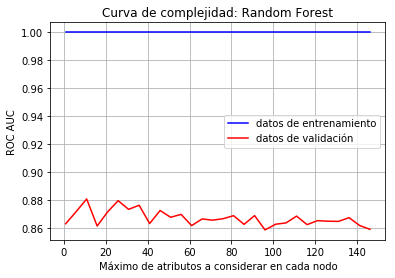

In [68]:
##CORREGIDO


roc_auc_forest_train = []
roc_auc_forest_test = []

max_features_list = np.arange(1,150,5)

for max_features in max_features_list:
        
    lista_aucs_train = []
    lista_aucs_test = []
    
    for train_index, test_index in kf.split(X_dev):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
        y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]

        forest = RandomForestClassifier(n_estimators=200, max_features=max_features, n_jobs=-1)
        forest.fit(X_train, y_train)

        y_pred_test = forest.predict_proba(X_test)
        y_pred_train = forest.predict_proba(X_train)
        
        y_pred_test=y_pred_test[:,1]
        y_pred_train=y_pred_train[:,1]
        
        #print(y_pred_train)
            
        roc_auc_test=sklearn.metrics.roc_auc_score(y_test, y_pred_test, sample_weight=None)
        roc_auc_train=sklearn.metrics.roc_auc_score(y_train, y_pred_train, sample_weight=None)
        
        roc_auc_test=sklearn.metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:,1], sample_weight=None)
        roc_auc_train=sklearn.metrics.roc_auc_score(y_train, forest.predict_proba(X_train)[:,1], sample_weight=None)
        
        lista_aucs_train.append(roc_auc_train)
        lista_aucs_test.append(roc_auc_test)


    roc_auc_forest_train.append( np.mean(lista_aucs_train) )
    roc_auc_forest_test.append( np.mean(lista_aucs_test) )


plt.figure()
plt.plot(max_features_list, np.array(roc_auc_forest_train), color = 'blue', label = 'datos de entrenamiento')
plt.plot(max_features_list, np.array(roc_auc_forest_test), color = 'red', label = 'datos de validación')
plt.xlabel('Máximo de atributos a considerar en cada nodo')
plt.ylabel('ROC AUC')
plt.title('Curva de complejidad: Random Forest')
plt.grid(True)
plt.legend()

In [71]:
roc_auc_train=sklearn.metrics.roc_auc_score(y_train, forest.predict_proba(X_train)[:,1], sample_weight=None)
print(forest.predict_proba(X_train)[:,1])
roc_auc_train

[0.86  0.865 0.96  0.83  0.165 0.09  0.75  0.03  0.17  0.665 0.035 0.81
 0.97  0.11  0.94  0.8   0.065 0.06  0.09  0.845 0.02  0.125 0.25  0.765
 0.81  0.085 0.105 0.94  0.975 0.06  0.86  0.225 0.03  0.78  0.175 0.04
 0.98  0.255 0.845 0.905 0.91  0.255 0.05  0.94  0.96  0.09  0.915 0.73
 0.87  0.04  0.005 0.17  0.77  0.295 0.115 0.15  0.67  0.025 0.945 0.275
 0.05  0.095 0.105 0.275 0.2   0.205 0.92  0.915 0.92  0.085 0.015 0.07
 0.72  0.04  0.185 0.775 0.105 0.745 0.86  0.065 0.14  0.75  0.775 0.28
 0.135 0.965 0.84  0.12  0.16  0.225 0.06  0.805 0.9   0.03  0.24  0.09
 0.205 0.095 0.265 0.05  0.12  0.855 0.725 0.09  0.2   0.89  0.055 0.055
 0.91  0.08  0.055 0.245 0.185 0.965 0.76  0.92  0.005 0.925 0.195 0.845
 0.105 0.795 0.095 0.845 0.08  0.89  0.09  0.115 0.945 0.025 0.11  0.02
 0.89  0.015 0.125 0.955 0.805 0.135 0.03  0.16  0.96  0.795 0.08  0.05
 0.915 0.095 0.91  0.79  0.13  0.92  0.915 0.12  0.82  0.015 0.905 0.96
 0.955 0.75  0.16  0.975 0.91  0.885 0.115 0.04  0.04  0.95 

1.0

In [72]:
y_train

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1])

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.0187, 0.0374, 0.0467, 0.0654, 0.0935, 0.1495,
       0.1589, 0.1776, 0.1869, 0.2243, 0.2804, 0.2991, 0.3178, 0.3271,
       0.3458, 0.4019, 0.4206, 0.4673, 0.4766, 0.5327, 0.5981, 0.6542,
       0.6729, 0.6822, 0.7009, 0.8131, 0.8598, 0.8692, 0.9159, 0.9533,
       0.9813, 1.    ])

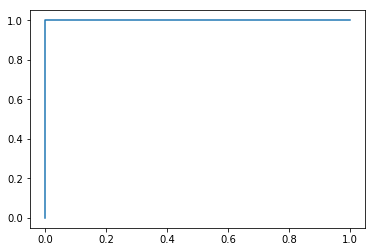

In [82]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_train, y_pred_train, pos_label=1)
plt.plot(fpr,tpr)
tpr
fpr

### Discusión

Para el caso del RandomForest, la complejidad del modelo viene dada por la cantidad de atributos disponibles en cada nodo de cada árbol. Mientras se permitan utilizar más atributos, aumentarán las posibles decisiones que tome cada árbol, y de ese modo la cantidad de parámetros libres.

En primer lugar, podemos notar que la métrica ROC AUC tiene un valor óptimo sobre los datos de entrenamiento para cualquier valor de la complejidad, nuevamente con valores menores sobre los datos de validación. Este error sobre validación disminuye ligeramente al aumentar la cantidad de atributos disponibles, pero presenta cierta dispersión. 

Creemos que el constante valor perfecto de la ROC AUC sobre los datos de entrenamiento se debe a el bajo sesgo del algortimo, pues se utilizan árboles que pueden crecer profundo (lo cual resulta en un bajo sesgo para cada árbol). El promediado sobre el conjunto de árboles resulta en una reducción de la varianza. 



In [ ]:
tuned_parameters = [{'n_estimators':[200], 'max_features':range(1, 100, 5), 'max_depth':range(1,11)}]
%time GridSearch(RandomForestClassifier(random_state=1234, n_jobs = -1), tuned_parameters)

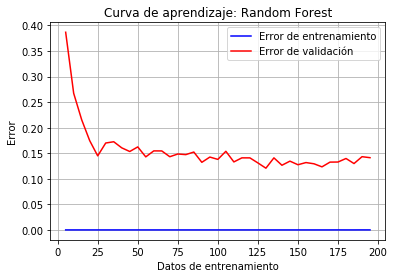

In [15]:
train_sizes, train_scores_forest, valid_scores_forest = learning_curve(
    RandomForestClassifier(n_estimators=200, max_features=1, max_depth=5, n_jobs=-1), X_dev_np, y_dev_np, train_sizes=range(5, 199, 5), cv=5, 
    scoring = 'roc_auc', random_state=1234, n_jobs=-1)

plt.figure()
plt.plot(train_sizes, 1-np.mean(train_scores_forest, axis = 1), color = 'blue', label = 'Error de entrenamiento')
plt.plot(train_sizes, 1-np.mean(valid_scores_forest, axis = 1), color = 'red', label = 'Error de validación')
#plt.ylim(0, 0.6)
plt.xlabel('Datos de entrenamiento')
plt.ylabel('Error')
plt.title('Curva de aprendizaje: Random Forest')
plt.grid(True)
plt.legend()
#print(train_scores_forest)

### Discusión
Vemos aquí que el error sobre los datos de entrenamiento es prácticamente nulo. Esto indica que el sesgo (al menos considerando sólo los datos de entrenamiento) _parece_ ser muy bajo. Por otro lado, el error de validación disminuye notablemente al aumentar la cantidad de datos de entrenamiento de 5 a 100. Su disminución se frena gradualmente y, pasado ese rango, parece estabilizarse. 
Observando la distancia entre curvas, vemos que la varianza disminuye de igual manera, y su disminución también se hace menos pronunciada aumentando la cantidad de datos. Al pasar los 125 datos, parece haberse estabilizado. 

Teniendo en cuenta lo anterior, podemos indicar que no resultaría útil conseguir más datos para mejorar la performance del modelo.


## Punto Extra

In [51]:
# Extra

from sklearn.ensemble import GradientBoostingClassifier

tuned_parameters = {'n_estimators':range(1,200), 'learning_rate':np.linspace(0.1,1,100) ,'max_depth':range(1,11)}
#tuned_parameters = {'n_estimators':range(1,100)}
n_iter = 50

%time RandomSearch(GradientBoostingClassifier(random_state=1234), tuned_parameters, n_iter)

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'n_estimators': 168, 'max_depth': 1, 'learning_rate': 0.15454545454545454}

Grid scores on development set:

0.877 (+/-0.091) for {'n_estimators': 90, 'max_depth': 1, 'learning_rate': 0.96363636363636362}
0.785 (+/-0.134) for {'n_estimators': 188, 'max_depth': 10, 'learning_rate': 0.84545454545454535}
0.882 (+/-0.083) for {'n_estimators': 122, 'max_depth': 3, 'learning_rate': 0.65454545454545454}
0.864 (+/-0.141) for {'n_estimators': 56, 'max_depth': 4, 'learning_rate': 0.97272727272727266}
0.801 (+/-0.114) for {'n_estimators': 199, 'max_depth': 5, 'learning_rate': 0.47272727272727266}
0.878 (+/-0.099) for {'n_estimators': 162, 'max_depth': 3, 'learning_rate': 0.24545454545454545}
0.885 (+/-0.064) for {'n_estimators': 67, 'max_depth': 2, 'learning_rate': 0.3545454545454545}
0.802 (+/-0.123) for {'n_estimators': 47, 'max_depth': 8, 'learning_rate': 0.28181818181818186}
0.820 (+/-0.114) for {'n_estimat

### Discusión

Al realizar la GridSearch sobre los hiperparámetros ```max_features``` y ```max_depth``` del algoritmo RandomForest con 200 árboles, observamos que los puntajes de ROC AUC obtenidos fueron de aproximadamente 0.86-0.87 en general, con poca dispersión ente ellos. 

Por otro lado, al utilizar la RandomSearch sobre el algoritmo GradientBoost obtenemos resultados de la métrica muy variables entre sí. 

In [22]:
# Competencia

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

X_eval_np = np.array(X_eval)
y_eval_np = np.array(y_eval).ravel()

models = [
    DecisionTreeClassifier(max_depth= 2, criterion= 'entropy'),
    KNeighborsClassifier(p=1, n_neighbors= 51, weights= 'distance'),
    LinearDiscriminantAnalysis(shrinkage= 'auto', solver= 'lsqr'),
    GaussianNB(priors = None),
    RandomForestClassifier(max_features=21, n_estimators= 200),
    LinearSVC(C=0.001539926526059492),
    GradientBoostingClassifier(n_estimators= 168, learning_rate= 0.15454545454545454, max_depth=1)
]

print("ROC AUCs para diferentes modelos:")
for model in models:

    model.fit(X_dev_np, y_dev_np)
    y_pred = model.predict(X_eval_np)
    r = sklearn.metrics.roc_auc_score(y_eval_np, y_pred, sample_weight=None)
    #print("ROC AUC de {0}:".format(str(model)))
    display(model)
    display(r)
    print("==============================")


ROC AUCs para diferentes modelos:


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.5915159764080626

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=51, p=1,
           weights='distance')

0.7109987685527253

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=0.0001)

0.6975176615464386

GaussianNB(priors=None, var_smoothing=1e-09)

0.6822217901354592

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=21, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.6830967658305788

LinearSVC(C=0.001539926526059492, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

0.7272344286732776

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15454545454545454, loss='deviance',
              max_depth=1, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=168,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

0.6597316741201633

In [37]:
best_model = KNeighborsClassifier(p=1, n_neighbors= 51, weights= 'distance')
best_model.fit(X_dev_np, y_dev_np)
all_probas = best_model.predict_proba(np.array(X_competencia))

true_proba = list()
for x in all_probas:
    true_proba.append(x[1])
    
final_res = pd.DataFrame(index=X_competencia.index)
final_res["output"] = np.around(true_proba, decimals=4)

display(final_res)
final_res.to_csv("y_competencia.csv")

auc_roc_held_out = sklearn.metrics.roc_auc_score(np.array(y_eval).ravel(), best_model.predict(np.array(X_eval)), sample_weight=None)
f = open("auc_roc_competencia.txt", "w")
f.write(str(auc_roc_held_out - 0.02)) #usamos el auc roc del held out, menos 2 puntos porcentuales para ajustar sobreestimacion
f.close()

,output
index,
501,0.5478
502,0.5669
503,0.5492
504,0.6299
505,0.2931
...,...
4995,0.3520
4996,0.3325
4997,0.8071


## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
